<a href="https://colab.research.google.com/github/keabao625/demo-test-repo/blob/main/12_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("12_1.ipynb")

# Question 1

We briefly touched on tokenization last week, now let's use the tiktoken tokenizer for GPT-4o.

- In the tokenization of the phrase  "tiktoken is great!", what token(s) corresponds to the word "is"?
- Do phrase 1 and phrase 2 have the same number of tokens? Why or why not?
- What sentence corresponds to the tokens `[3238, 3239, 316, 8879, 634, 532, 57026, 514]`?

In [ ]:
%pip install tiktoken

import tiktoken

enc = tiktoken.encoding_for_model("gpt-4o")

In [ ]:
...

In [ ]:
phrase = 'Colorless green ideas sleep furiously'
number_of_tokens_in_phrase1 = ...
number_of_tokens_in_phrase1

In [ ]:
phrase = 'Colourless green ideas sleeep furiously'
number_of_tokens_in_phrase2 = ...
number_of_tokens_in_phrase2

In [ ]:
sentence = ...
sentence

The following few examples are based on [Anthropic's Prompt Engineering Interactive Tutorial](https://github.com/anthropics/prompt-eng-interactive-tutorial/tree/master).

You can refer to the following resources in deciding how to write the prompts in the following questions:

- https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview
- https://github.com/anthropics/prompt-eng-interactive-tutorial
- https://ai.google.dev/gemini-api/docs/prompting-intro
- https://platform.openai.com/docs/guides/prompt-engineering
- https://services.google.com/fh/files/misc/gemini-for-google-workspace-prompting-guide-101.pdf

## Question 2

Let's start by using a small open model which we can download and perform inference with locally: [SmolLM v2](https://huggingface.co/HuggingFaceTB/SmolLM2-360M).

Use this model to generate a haiku about robots. You need to set the `max_new_tokens` parameter to `model.generate()` to allow enough tokens to be returned to complete the haiku.

The returned outputs include the original prompt as inputs. Write code to remove this from the output.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# use device = "cpu" if you're running on a machine without a GPU
# use device = "cuda" if you're running on a machine with a GPU
device = "cpu"
checkpoint = "HuggingFaceTB/SmolLM2-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [ ]:
prompt = ...
inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
outputs = model.generate(
    inputs,
    max_new_tokens= ...
    )
output_text = tokenizer.decode(outputs[0])
output_without_prompt = ...
print(output_without_prompt)

### Question 3

Increasing the temperature parameter of a model makes the output more random rather than more predictable. Increase the temperature parameter from its default of 0.2. At what point does the haiku stop being three lines of 7-5-7 syllables?

In [ ]:
prompt = ...
inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
outputs = model.generate(
    inputs,
    max_new_tokens= ...
    do_sample = True,
    temperature = ...
    )
output_text = tokenizer.decode(outputs[0])
print(output_text)

### Question 4

As well as creative tasks, Large Language Models can be used for knowledge-based tasks. We'll see whether the model can determine the country in which companies were founded, and use code-based evaluation to check.

- Based on the code you've already written. Write a function which takes the input text, tokenizes it, generates the outputs, turns them back into words and returns only the new generated text.
- Write a prompt template for determining the country in which a company was founded
- Examine the output for a few examples. Depending on your prompt you may need to split the output string and remove whitespace to get only the country name in the output. You can also try starting the output with `{"country": "` to generate json`.
- Call this function for all the companies in the dataframe, and count how many the model got right.

In [ ]:
company_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_oldest_companies")[0].sample(20, random_state=211)

company_df

In [ ]:
def generate_completion(prompt, max_new_tokens, device="cpu"):
  ...

In [ ]:
...

In [ ]:
...

In [ ]:
def predict_country(company):
  ...

In [ ]:
company_df['Country_pred'] = company_df['Company'].apply(predict_country)

In [ ]:
accuracy = ...
accuracy

### Question 5

Google's Gemini models are closed, and accessible via an API (for free to holders of Google accounts, with a request per minute limit).

- Get a Gemini API key following the instructions [here](https://ai.google.dev/gemini-api/docs/api-key). Note that some types of Google Accounts have Google API Studio access disabled.
- Write a function to predict the companies' countries using the Gemini API. You can refer to [these docs](https://ai.google.dev/gemini-api/docs/text-generation?lang=python) to understand the model's API. Don't forget to respect the 60 requests/minute rate limit.
- Which model performs better?

In [ ]:
import google.generativeai as genai
import os

GEMINI_API_KEY = ...

genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [ ]:
def predict_country_gemini(company):
  ...
company_df['Country_pred_gemini'] = company_df['Company'].apply(predict_country_gemini)

In [ ]:
accuracy = ...
accuracy

### Question 6

Let's also try predicting the field the company is in.

- First, modify your Gemini example to predict the fields
- Second, change this example to include some few-shot examples in the prompt (normally we would only use few-shot examples which are not part of the data we're evaluating on). Does the performance improve?

In [ ]:
def predict_field_gemini(company):
  ...
company_df['Field_pred_gemini'] = company_df['Company'].apply(predict_field_gemini)
accuracy = ...
accuracy

In [ ]:
def predict_field_gemini_fewshot(company):
  ...
company_df['Field_pred_gemini_fewshot'] = company_df['Company'].apply(predict_field_gemini)
accuracy = ...
accuracy

##  Question 7

Let's use an LLM to complete one of the tasks we've previously used embeddings and a GBDT to solve: imdb sentiment classification. Using either Gemini or SmolLM2, predict the sentiment of each review. How well does this perform?

In [ ]:
import urllib.request
import tarfile
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# We're loading text data that is stored in a tar file into

n_examples = 200

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
urllib.request.urlretrieve(url, filename='aclImdb_v1.tar.gz')


texts = []
with tarfile.open('./aclImdb_v1.tar.gz', 'r:gz') as tf:
    m = tf.getmembers()
    neg_paths = [i for i in m if i.path.startswith('aclImdb/train/neg') and i.path.endswith('.txt')]
    pos_paths = [i for i in m if i.path.startswith('aclImdb/train/pos') and i.path.endswith('.txt')]

    for i in neg_paths[:n_examples]:
        texts.append({
            'label': 'neg',
            'text': tf.extractfile(i).read().decode('utf8'),
        })
    for i in pos_paths[:n_examples]:
        texts.append({
            'label': 'pos',
            'text': tf.extractfile(i).read().decode('utf8'),
        })

texts_df = pd.DataFrame(texts)
texts_df = texts_df.sample(20, random_state=211)

In [ ]:
def predict_imdb_sentiment(review):
  ...

In [ ]:
texts_df['label_pred'] = texts_df['text'].apply(predict_imdb_sentiment)

In [ ]:
accuracy = ...
accuracy

## Additional questions

### Question

Some tasks can't be evaluated by comparing the output directly to a label. Write an evaluation for the task of writing a haiku which uses cosine similarity to check whether the haiku [evokes a season](https://en.wikipedia.org/wiki/Haiku#Kigo).

### Question

Other tasks even require an LLM in the evaluation. Write an evaluation for haiku generation which uses an LLM to count [the number of syllables in each line](https://en.wikipedia.org/wiki/Haiku#On).

### Question

There are a number of benchmark tasks on which Large Language Models are often evaluated to compare their performance.

The [Winogrande](https://winogrande.allenai.org/) benchmark aims to test for commonsense reasoning by testing the completions of a sentence:


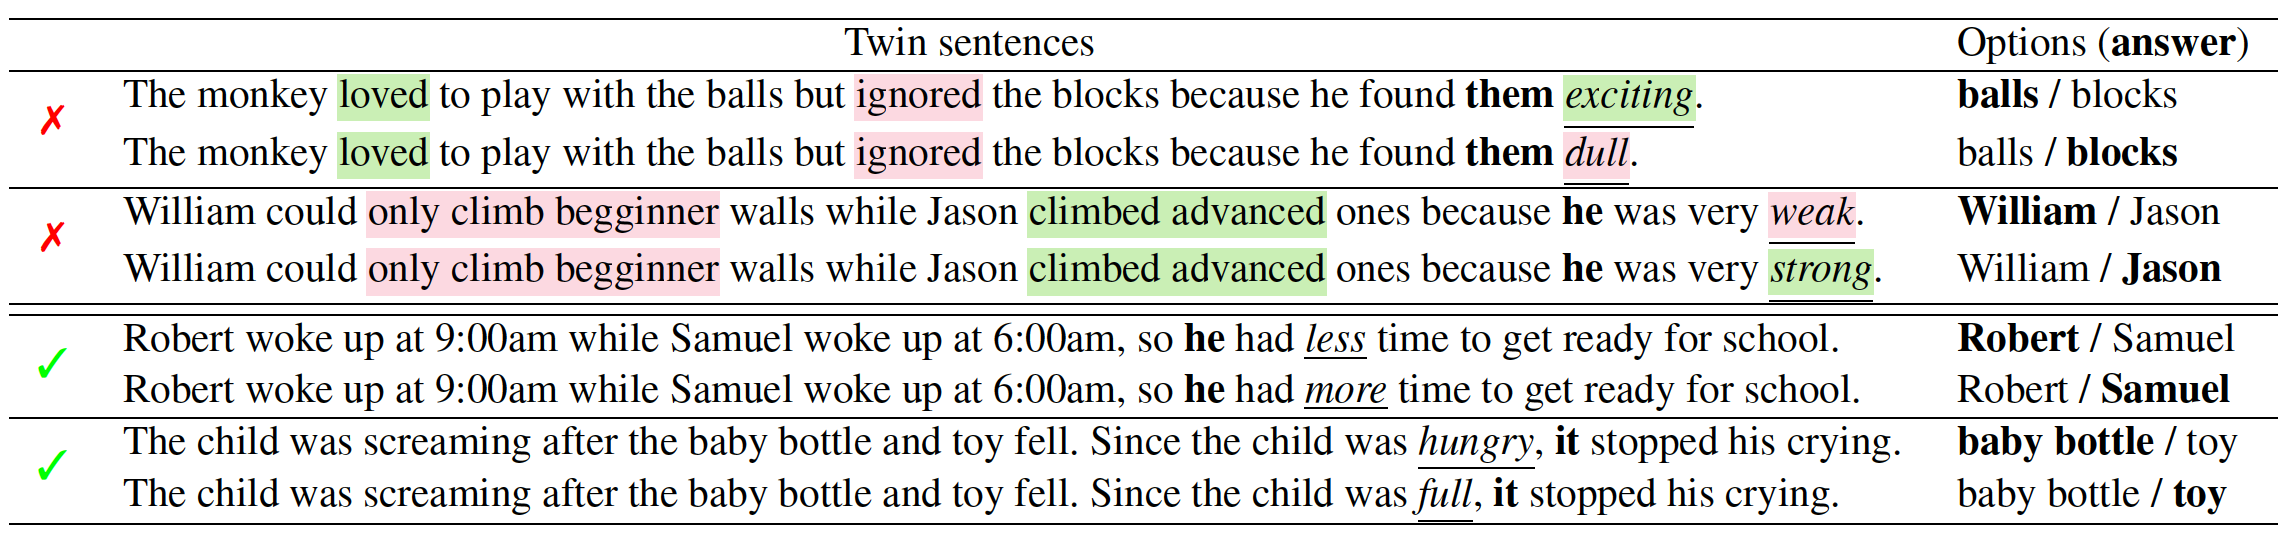


Write a prompt template that works for a single example from the Winogrande benchmark:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda"
checkpoint = "HuggingFaceTB/SmolLM2-360M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [ ]:
example = """Sarah was a much better surgeon than Maria so _ always got the easier cases.
(1) Sarah (2) Maria"""

...


max_new_tokens = ...
prompt = template.format(example=example)
inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
outputs = tokenizer.decode(model.generate(inputs, max_new_tokens=max_new_tokens)[0])

### Question

In order to run this benchmark on multiple examples, we need to write code that inserts the specific example into the prompt.

The examples are JSON objects in a line-delineated file, and each one has this format

```javascript
{"qID": "3FCO4VKOZ4BJQ6IFC0VAIBK4KTWE7U-2", "sentence": "Sarah was a much better surgeon than Maria so _ always got the easier cases.", "option1": "Sarah", "option2": "Maria", "answer": "2"}
```

1. Write a function which takes in an example in this JSON format
2. Write code which dowloads the Winogrande dataset from [this url](https://storage.googleapis.com/ai2-mosaic/public/winogrande/winogrande_1.1.zip) and runs inference on the first 100 dev examples
3. Evalute the performance of the model.

### Question

Download [GPT-2](https://huggingface.co/openai-community/gpt2), another open model and use it for the same tasks.

### Question

Other types of benchmark can have many possible completions, but are evaluated by determining which completion is considered most likely by the model. [HellaSwag](https://arxiv.org/pdf/1905.07830v1) is this type of benchmark.

Download the benchmark data from [here](https://github.com/rowanz/hellaswag/tree/master/data) and use `model.compute_transition_scores` to evaluate the models against this benchmark.

### Question

Use [Chain of Thought](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/chain-of-thought) for the Winograd, Sentiment Classification and Hellaswag tasks. For this to work, you need to parse the response out of the output correctly. Does this improve the performance of the Gemini model?

### Question

Gemini has [particular support](https://ai.google.dev/gemini-api/docs/code-execution?lang=python) for generating and running Python code.

Use this to solve this question ([from lab 2](https://github.com/compss211/compss211/blob/main/labs/2-2_review/2-2_review_raw.ipynb)):*italicized text*



> Suppose that a phone number can be written in these formats:
```
>    +1 (510) 642-6000
>    (510) 642-6000
>    642-600
>    5106426000
>    510 642 6000
```
> Write a regular expression which extracts the international dialing code and area code from these phone numbers.


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)